# ABOVE AC9 Data Processing  

## Checking Sample Replicates - Manually remove poor samples

**Authors:** Catherine Kuhn, Elena Terzić and Anna Simpson

**Last Updated:** September 17th, 2018

### Import libraries

In [1]:
### Import the required python libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import glob
import os
import sys
import csv
from scipy import interpolate
from os import listdir
from os.path import isfile, join
import matplotlib.gridspec as gridspec

### Functions

#### Plots absorption/attenuation for multiple replicates (combination of site_date, filtered/unfiltered, and a/c)

In [2]:
def plotting_absorption(list_of_files, check='F', title='Title'):
    labels_list = []
    count = 0
    for filename in range(len(list_of_files)): 
            count += 10
            df = pd.read_csv(list_of_files[filename], skiprows = 0, delimiter= '\t')         
            df.reset_index(inplace=True, drop=False)
            df.rename(columns = {'c_mean':'mean', 'a_mean':'mean', 'c_std':'std','a_std':'std'}, inplace = True)
            Sensor, Date, Site, Sample_Type, Abs_Type, Rep, T1, T2= list_of_files[filename].split('/')[-1].split('.')[0].split('_')
            repname = 'Rep '+Rep
            labels_list.append(repname)
            plt.plot('wl','mean',data=df,label=repname)
            #plt.scatter('wl', 'a_mean', data = df)
            plt.errorbar('wl', 'mean', yerr='std', fmt='k-', linewidth=0.5, data = df) 
            #if check == 'F':
            #    pass
            #else:
            #    if 'FLAG' in conf_check[list_of_files[filename]]:
            #        plt.text(650, df['mean'].mean(), 'FLAG '+repname, fontsize=15, color="red")
    plt.ylabel('a [1/m]')
    plt.title(title)
    plt.legend(labels_list)
    return plt

In [3]:
from fopt_toolkit import fopt_toolkit as fp

## Inputs

In [4]:
store_figures_for_individ_reps = fp.make_dir('Figures/Check_individual_reps')

In [5]:
metadata_updated_filepath = os.path.abspath('..')+'/Metadata/project_metadata_updated.csv'
replicate_directory_name = '2_summary_stats_tempcor'
replicate_pass_directory_name = '3.1_summary_stats_pass_manual'

replicate_files_location = os.path.abspath('..')+'/Data/'+replicate_directory_name
replicate_pass_directory_location = os.path.abspath('..')+'/Data/'+replicate_pass_directory_name

## Read all file paths into dictionary

#### This loop goes through the rows of the metadata file, creates a dictionary in which the keys are date_site and the entries are dictionaries where the keys are SampleType_AnalysisType (example: fil_a) and the entries are lists of file directories.

In [6]:
metadata = pd.read_csv(metadata_updated_filepath, dtype={'Date': object}, skiprows=0, delimiter= '\t')
plotting_dict = {}
conf_check = {}
for index, row in metadata.iterrows():
    Site, Date, Analysis_Type, Sample_Type, Summary_file_path, Conf = row['Site'], row['Date'], row['Analysis_Type'], row['Sample_Type'], row['Summary_file_path'], row['Conf']
    if Sample_Type != 'cal':
        SiteDate = Site+'_'+str(Date)
        Type = Sample_Type+'_'+Analysis_Type
        conf_check[Summary_file_path] = Conf
        if SiteDate not in plotting_dict:
            plotting_dict[SiteDate] = {Type:[Summary_file_path]}
        elif Type not in plotting_dict[SiteDate]:
            plotting_dict[SiteDate][Type] = [Summary_file_path]
        else:
            plotting_dict[SiteDate][Type].append(Summary_file_path)
        

In [7]:
from math import exp
conf_check_2 = {}
for i in conf_check:
    df = pd.read_csv(i, skiprows = 0, delimiter= '\t')
    df.rename(columns = {'c_std':'std','a_std':'std'}, inplace = True)
    mean_std = float(df['std'].mean())
    if exp(mean_std) > exp(float(conf_check[i])+1):
        conf_check_2[i] = 'FLAG'
    else:
        conf_check_2[i] = ''

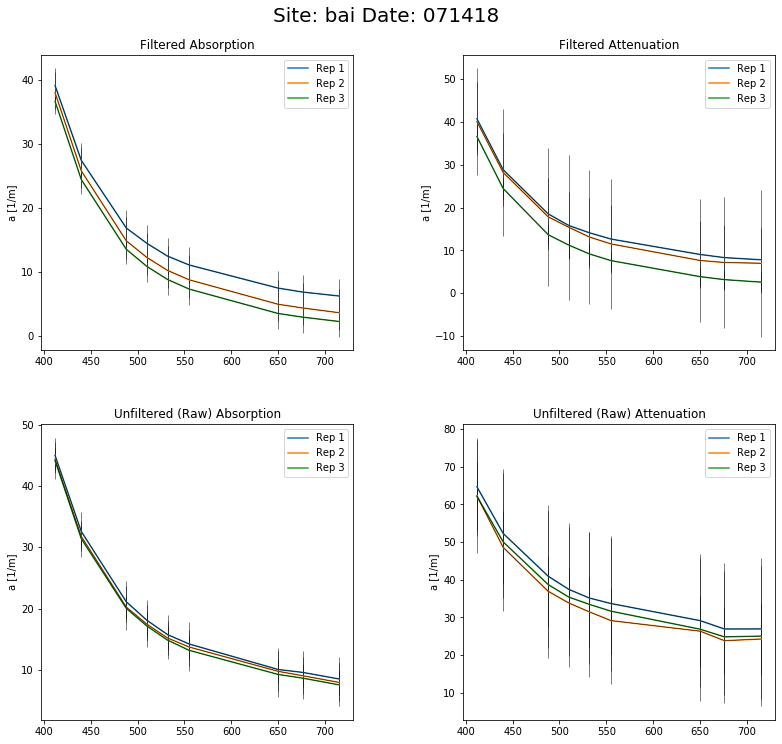

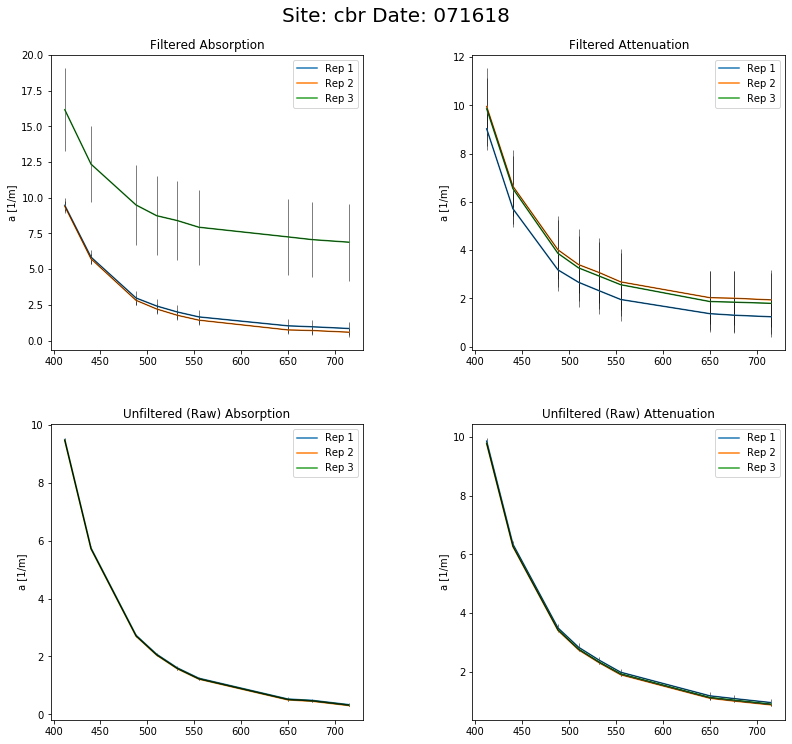

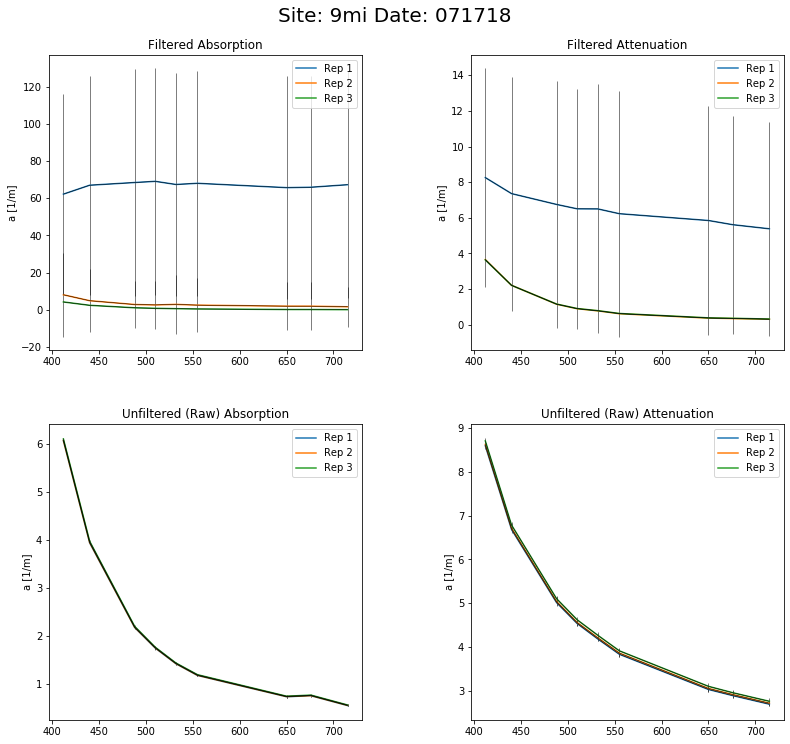

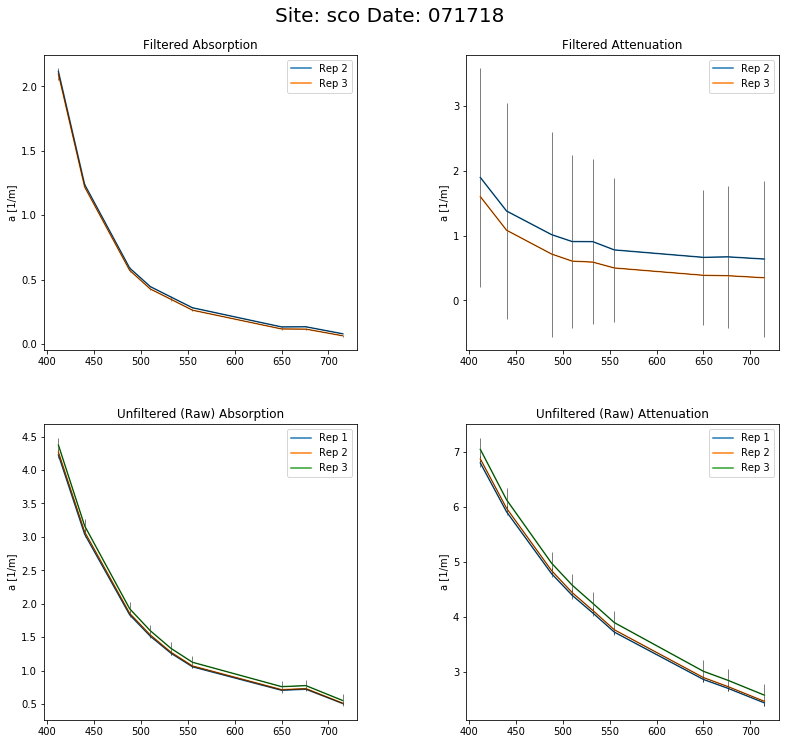

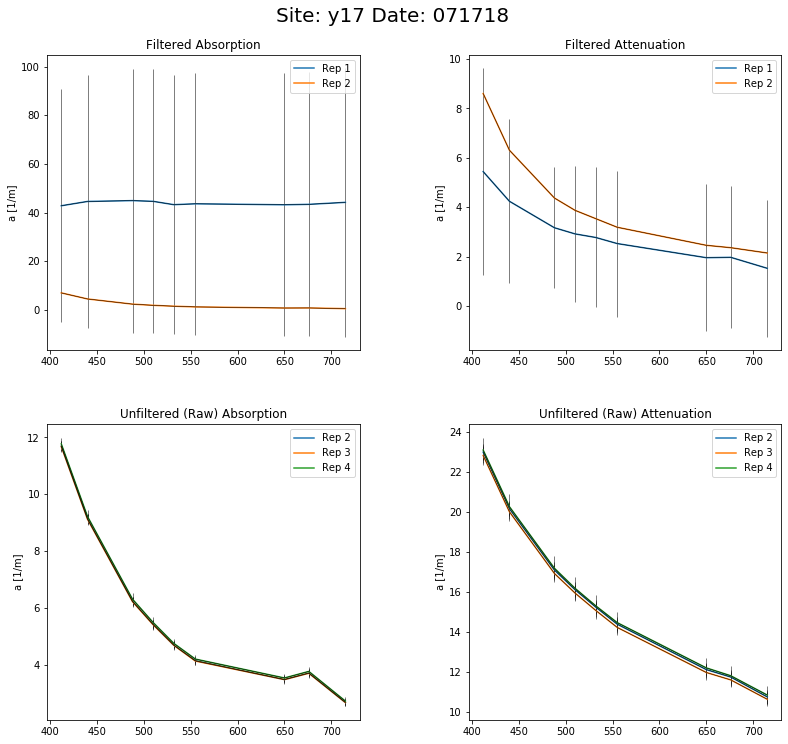

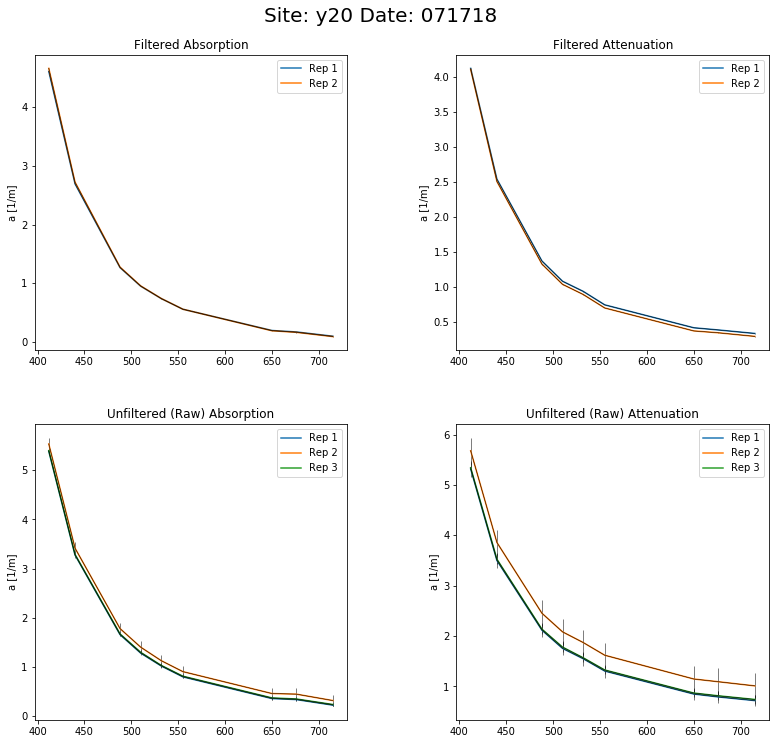

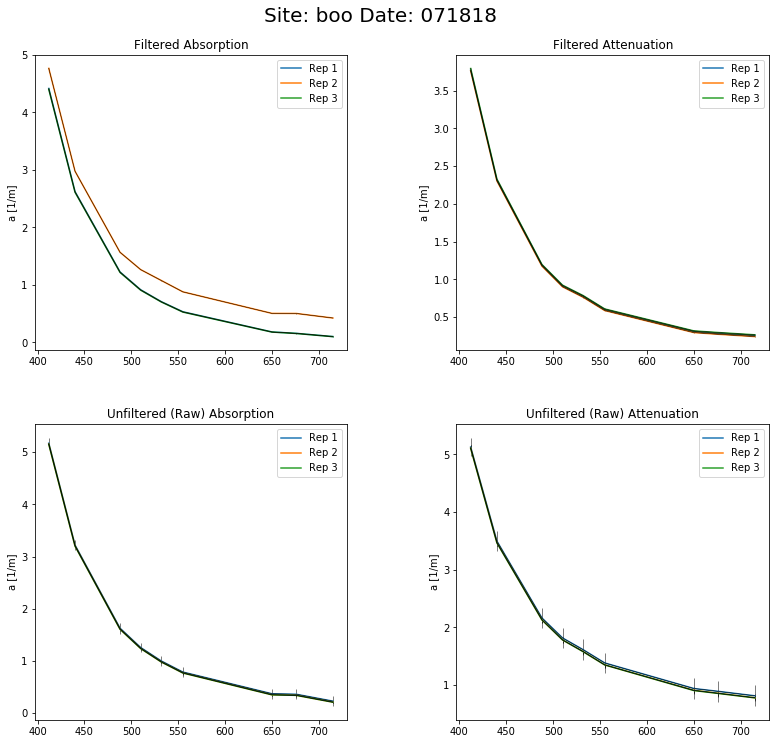

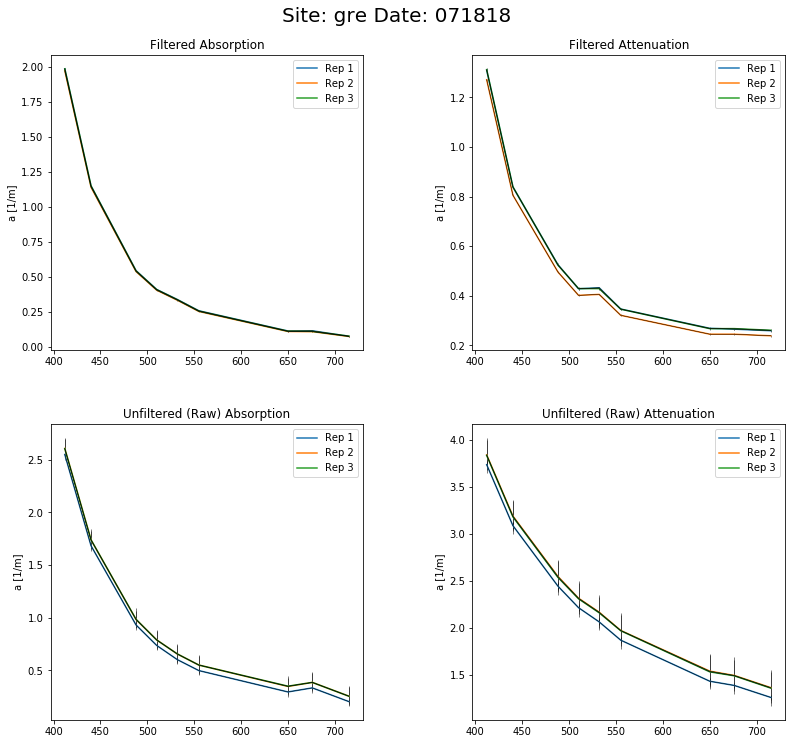

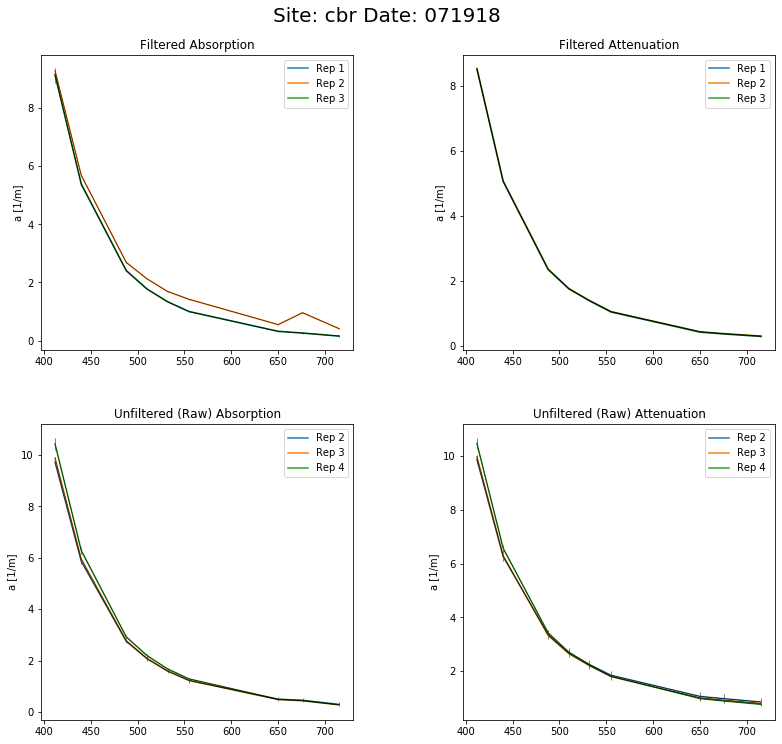

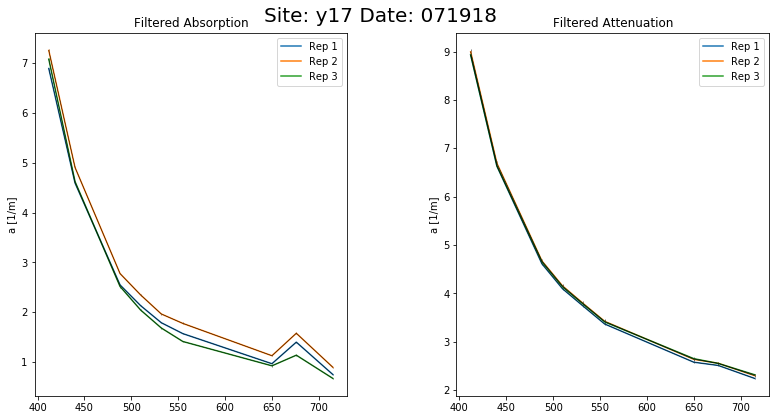

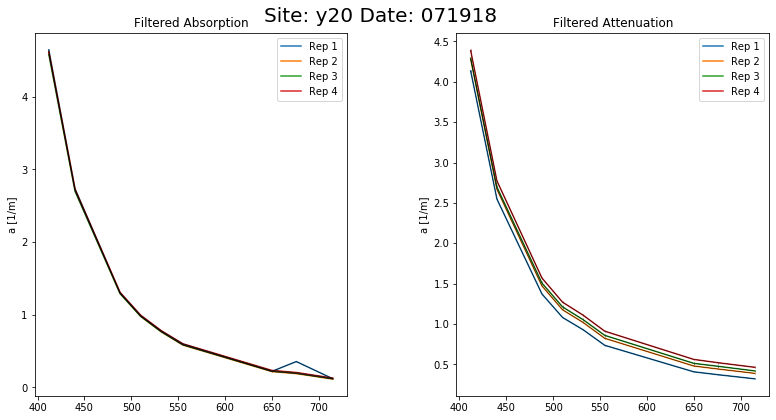

In [13]:
sample_types = {'fil':"Filtered",'raw':'Unfiltered (Raw)','cal':"Calibration"}
abs_types = {'a':'Absorption','c':'Attenuation'}

for i in plotting_dict:
    num_of_plots = len(plotting_dict[i])
    num_of_rows = int(num_of_plots/2)
    count = 0
    Site_all, Date_all = i.split('_')
    plt.subplots(num_of_rows, 2, figsize=(12, 5*num_of_rows+1))
    for sampleid in plotting_dict[i]:
        count += 1
        Sample_Type, Abs_Type = sampleid.split('_')
        plottitle = ' '.join([sample_types[Sample_Type],abs_types[Abs_Type]])
        plt.subplot(num_of_rows, 2, count)    
        my_plot = plotting_absorption(plotting_dict[i][sampleid], check=conf_check_2, title=plottitle)
        #dict_of_sampleids_and_plots[sampleid] = my_plot
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    my_plot.suptitle('Site: '+Site_all+' '+'Date: '+Date_all, fontsize=20)
    my_plot.savefig('../Figures/Check_individual_reps/'+Site_all+'_'+Date_all+'.png', bbox_inches='tight')
    my_plot.show()

## Manual removal

In [14]:
metadata_updated = pd.read_csv('../Metadata/project_metadata_updated.csv', dtype={'Date': object, 'Rep':object}, skiprows=0, delimiter= '\t')

#### Get a list of removed samples

In [15]:
r1 = fp.get_id('y17','071718','fil')

Site y17
Date 071718
Sample_Type fil


In [16]:
r2 = fp.get_id('9mi','071718','fil','1')

Site 9mi
Date 071718
Sample_Type fil
Rep 1


In [17]:
r3 = fp.get_id('cbr','071618','fil','a','3')

Site cbr
Date 071618
Sample_Type fil
Analysis_Type a
Rep 3


In [18]:
samples_to_remove = r1+r2+r3

#### Create a new colum in updated metadata for pass for fail on manual removal

In [19]:
metadata_updated['Pass_Manual_Removal'] = 'pass'

#### Label the samples that are to be removed with 'fail'

In [20]:
for i in samples_to_remove:
    metadata_updated.loc[metadata_updated.ID == i, 'Pass_Manual_Removal'] = 'fail'

** Make sure that calibration samples are also marked 'fail' so they don't pass on **

In [21]:
metadata_updated.loc[metadata_updated.Sample_Type == 'cal', 'Pass_Manual_Removal'] = 'fail'

#### Make a new file for 'passed' samples, put 'pass' samples in it, and update metadata file with new column for pass or fail for manual removal and new filepath for said file

In [22]:
new_path_cleaned = fp.make_dir('/Data/3.1_cor_summary_stats_cleaned_MANUAL/')

In [23]:
metadata_updated['Summary_file_path_cleaned_MANUAL'] = ''

In [24]:
for i in metadata_updated['Summary_file_path']:
    if metadata_updated.loc[metadata_updated.Summary_file_path == i, 'Pass_Manual_Removal'].max() == 'pass':
        new_path = new_path_cleaned+'/'+i.split('/')[-1]
        my_command = ' '.join(['cp',i,new_path])
        os.system(my_command)
        metadata_updated.loc[metadata_updated.Summary_file_path == i, 'Summary_file_path_cleaned_MANUAL'] = new_path
    else:
        metadata_updated.loc[metadata_updated.Summary_file_path == i, 'Summary_file_path_cleaned_MANUAL'] = None

In [25]:
metadata_updated.to_csv('../Metadata/project_metadata_updated.csv', sep='\t',index=False)

### Recheck individual reps in case any that should be removed were swamped by even worse reps

#### metadata already loaded as pd dataframe 'metadata_updated'

In [26]:
sample_types = {'fil':"Filtered",'raw':'Unfiltered (Raw)','cal':"Calibration"}
abs_types = {'a':'Absorption','c':'Attenuation'}

for i in plotting_dict_update:
    num_of_plots = len(plotting_dict_update[i])
    num_of_rows = num_of_plots/2
    count = 0
    Site_all, Date_all = i.split('_')
    plt.subplots(num_of_rows, 2, figsize=(12, 5*num_of_rows+1))
    for sampleid in plotting_dict_update[i]:
        count += 1
        Sample_Type, Abs_Type = sampleid.split('_')
        plottitle = ' '.join([sample_types[Sample_Type],abs_types[Abs_Type]])
        plt.subplot(num_of_rows, 2, count)    
        my_plot = plotting_absorption(plotting_dict_update[i][sampleid], check=conf_check_2, title=plottitle)
        #dict_of_sampleids_and_plots[sampleid] = my_plot
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    my_plot.suptitle('Site: '+Site_all+' '+'Date: '+Date_all, fontsize=20)
    my_plot.savefig('../Figures/Check_individual_reps/'+Site_all+'_'+Date_all+'.png', bbox_inches='tight')
    my_plot.show()

NameError: name 'plotting_dict_update' is not defined